In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from wordcloud import WordCloud
from collections import Counter
import re
pd.set_option('display.max_columns', None)


In [27]:
df_routes=pd.read_parquet(r"..\..\dados\rotas_historico_categorizado.parquet")
df_historico_distancia=pd.read_parquet(r"..\..\dados\routes_dist_km_percorridos_historico.parquet")
df_historico_distancia=df_historico_distancia.merge(df_routes,on='route_id')
df_historico_distancia['data_referencia']=pd.to_datetime(df_historico_distancia['data_referencia'],format='%Y%m')
df_frequencias = pd.read_parquet(r"..\..\dados\frequencies_historico_categorizado.parquet")


In [28]:
df_passageiros_historico = pd.read_parquet("..\..\dados\passageiros_unificado.parquet")
df_passageiros_historico['data']=pd.to_datetime(df_passageiros_historico['data']).dt.to_period("M")
df_passageiros_historico=df_passageiros_historico.groupby(['linha','route_id','data']).sum().reset_index()
df_passageiros_historico['year']=df_passageiros_historico['data'].dt.year

df_passageiros_historico=df_passageiros_historico[['linha', 'route_id', 'data', 'year', 
       'passageiros_dinheiro', 'passageiros_comum', 
       'passageiros_integracao_metro_cptm',
       'passageiros_integracao_metro_cptm_mensal', 'passageiros_pagantes',
       'passageiros_integracao_onibus', 'passageiros_gratuitos',
       'passageiros_gratuitos_estudante', 'passageiros_total', 'passageiros_vale_transporte',
       'passageiros_integracao',]]

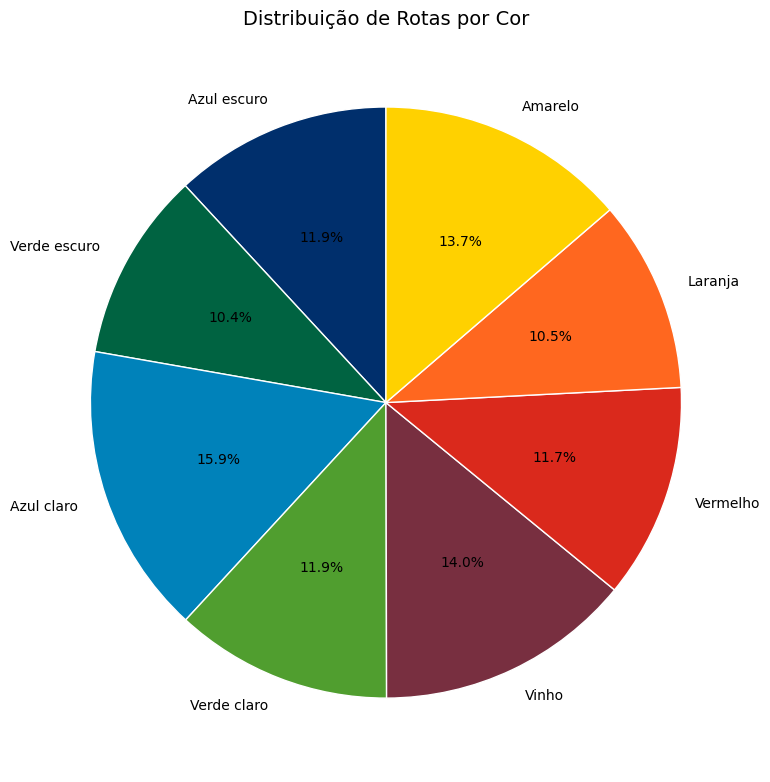

In [29]:
# Agrupa os dados
df_pizza = df_routes.groupby("route_color").count()[['route_id']].reset_index()

# Mapeia os nomes das cores (opcional, apenas pra legenda mais bonita)
map_cores = {
    "509E2F": "Verde claro",
    "002F6C": "Azul escuro",
    None: "Sem cor",
    "FFD100": "Amarelo",
    "DA291C": "Vermelho",
    "006341": "Verde escuro",
    "0082BA": "Azul claro",
    "FF671F": "Laranja",
    "782F40": "Vinho"
}

# Aplica o nome amigável
df_pizza['nome_cor'] = df_pizza['route_color'].map(map_cores)

# Define a lista de cores no formato aceito pelo matplotlib
cores = [
    f"#{c}" if isinstance(c, str) else "#D3D3D3"  # cinza claro se for None
    for c in df_pizza['route_color']
]

# Cria o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(
    df_pizza['route_id'],
    labels=df_pizza['nome_cor'],
    colors=cores,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Distribuição de Rotas por Cor', fontsize=14)
plt.tight_layout()
plt.show()

In [30]:
df_pizza = df_routes.groupby("noturna").count()[['route_id']].reset_index()
print(df_pizza.to_latex(index=False))

\begin{tabular}{rr}
\toprule
noturna & route_id \\
\midrule
False & 1168 \\
True & 411 \\
\bottomrule
\end{tabular}



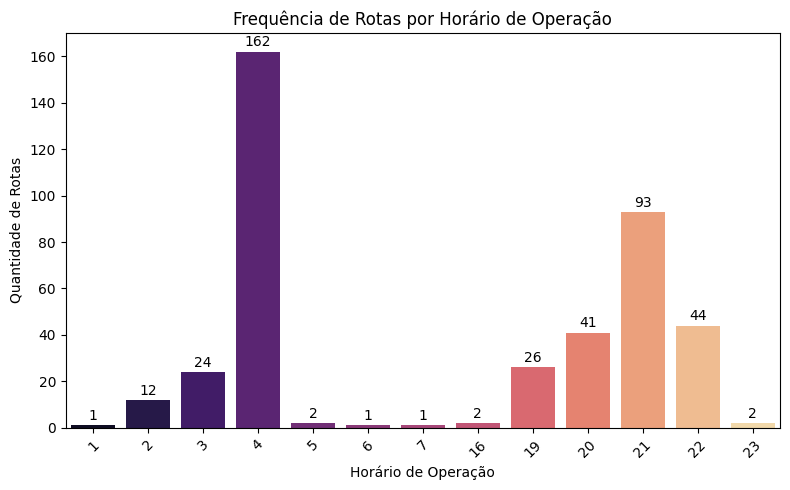

In [31]:
rotas_filtradas=df_routes[df_routes.noturna==True]
coluna='horas_operacao'
titulo="Boxplot do horário de operação das rotas noturnas"

# Contagem de cada categoria
frequencia = rotas_filtradas[coluna].astype(int).value_counts().sort_index()

# Gráfico de barras
plt.figure(figsize=(8,5))
ax = sns.barplot(x=frequencia.index, y=frequencia.values, palette="magma")

# Adiciona rótulo de dados em cada barra
for i, v in enumerate(frequencia.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)

plt.xlabel('Horário de Operação')
plt.ylabel('Quantidade de Rotas')
plt.title('Frequência de Rotas por Horário de Operação')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
df_pizza = df_routes.groupby("direcoes").count()[['route_id']].reset_index()
print(df_pizza.to_latex(index=False))

\begin{tabular}{lr}
\toprule
direcoes & route_id \\
\midrule
Circular & 497 \\
Não circular & 1082 \\
\bottomrule
\end{tabular}



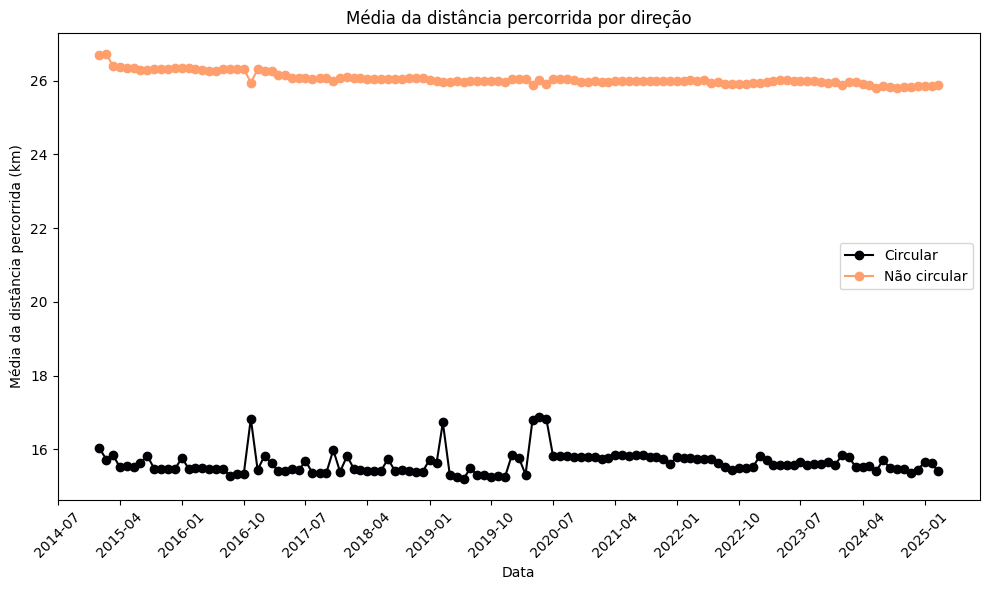

In [33]:
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np
# Agrupar por data e direção, calculando a média
df_media = df_historico_distancia.groupby(['data_referencia', 'direcoes'])['distancia_km_percorrido'].mean().reset_index()

# Obter direções únicas
direcoes_unicas = df_media['direcoes'].unique()

plt.figure(figsize=(10,6))
colors = cm.magma(np.linspace(0, 0.8, len(direcoes_unicas)))

# Plotar cada direção com uma linha
for i, direcao in enumerate(direcoes_unicas):
    subset = df_media[df_media['direcoes'] == direcao]
    plt.plot(subset['data_referencia'], subset['distancia_km_percorrido'], marker='o', label=f'{direcao}',color=colors[i])

# Formatar eixo x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=9))  # mostra a cada 3 meses
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # formato ano-mês

plt.xlabel("Data")
plt.ylabel("Média da distância percorrida (km)")
plt.title("Média da distância percorrida por direção")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

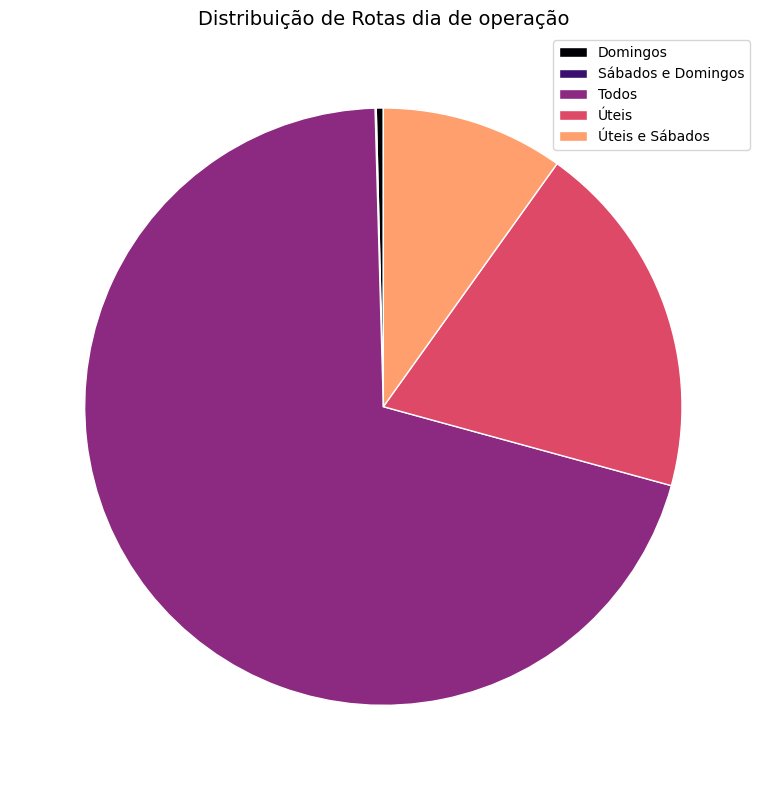

In [34]:
df_pizza=df_routes.copy()
df_pizza['service_ids']=df_pizza['service_ids'].apply(lambda x: x.split(",")[-1]).str.strip()
df_pizza = df_pizza.groupby("service_ids").count()[['route_id']].reset_index()
colors = cm.magma(np.linspace(0, 0.8, len(df_pizza['service_ids'])))

plt.figure(figsize=(8,8))
patches, texts = plt.pie(
    df_pizza['route_id'],
    # autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'},
    colors=colors
)
plt.legend(patches, df_pizza['service_ids'], loc="best")
plt.title('Distribuição de Rotas dia de operação', fontsize=14)
plt.tight_layout()
plt.show()


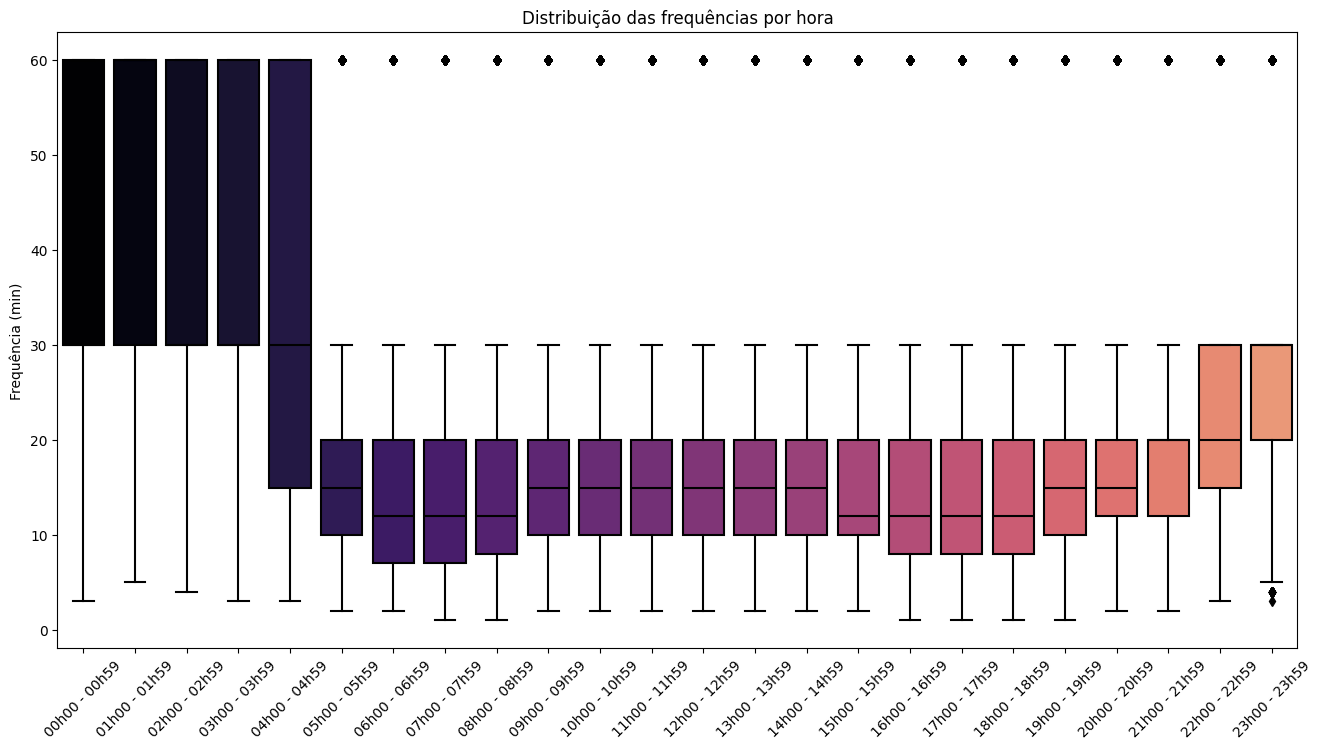

In [35]:
colors = cm.magma(np.linspace(0, 0.8, 25))
plt.figure(figsize=(16,8))
sns.boxplot(data=df_frequencias.iloc[:, 2:],palette=colors)
plt.xticks(rotation=45)
plt.ylabel('Frequência (min)')
plt.title('Distribuição das frequências por hora')
plt.show()


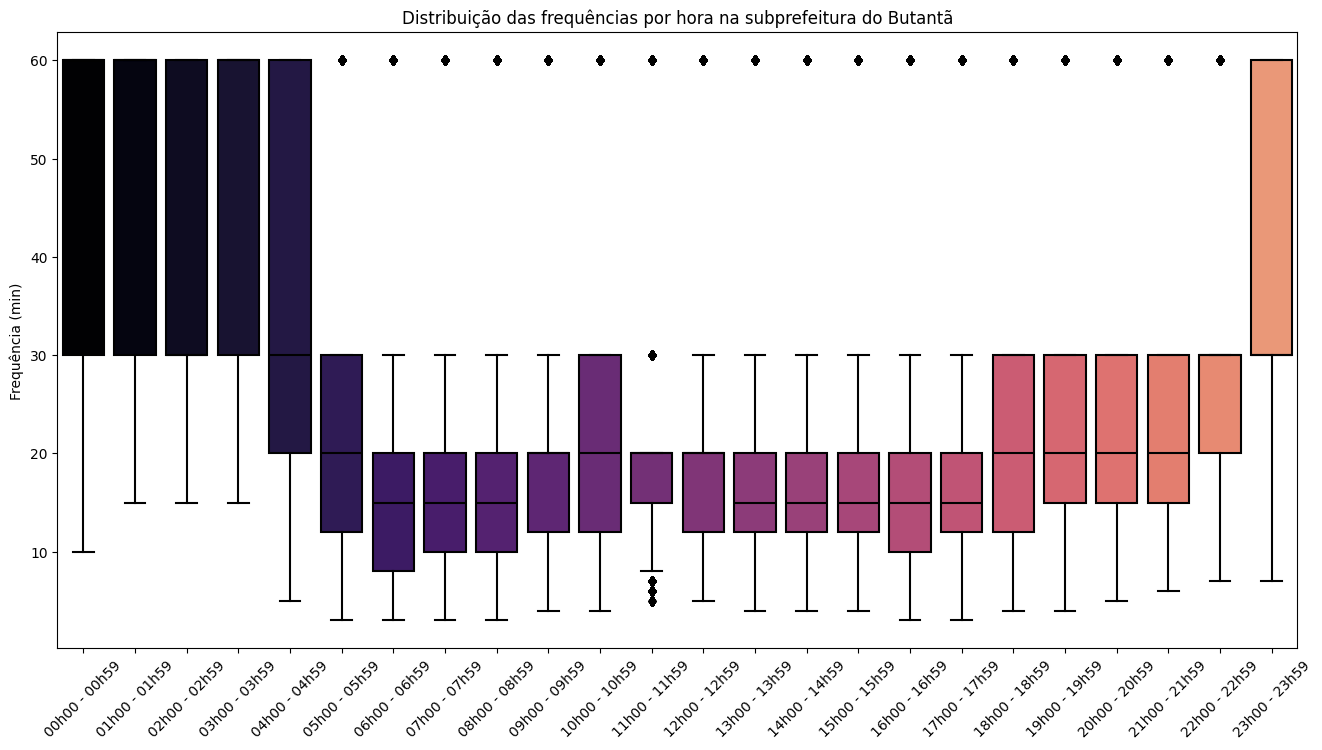

In [36]:
rotas_filtradas=df_routes[df_routes.subprefeituras.str.contains("Butantã")]
df_frequencias_filtrado=df_frequencias[df_frequencias.trip_id.str.replace("-","").str.contains("|".join(rotas_filtradas['route_id']),regex=True)]
plt.figure(figsize=(16,8))
sns.boxplot(data=df_frequencias_filtrado.iloc[:, 2:],palette=colors)
plt.xticks(rotation=45)
plt.ylabel('Frequência (min)')
plt.title('Distribuição das frequências por hora na subprefeitura do Butantã')
plt.show()

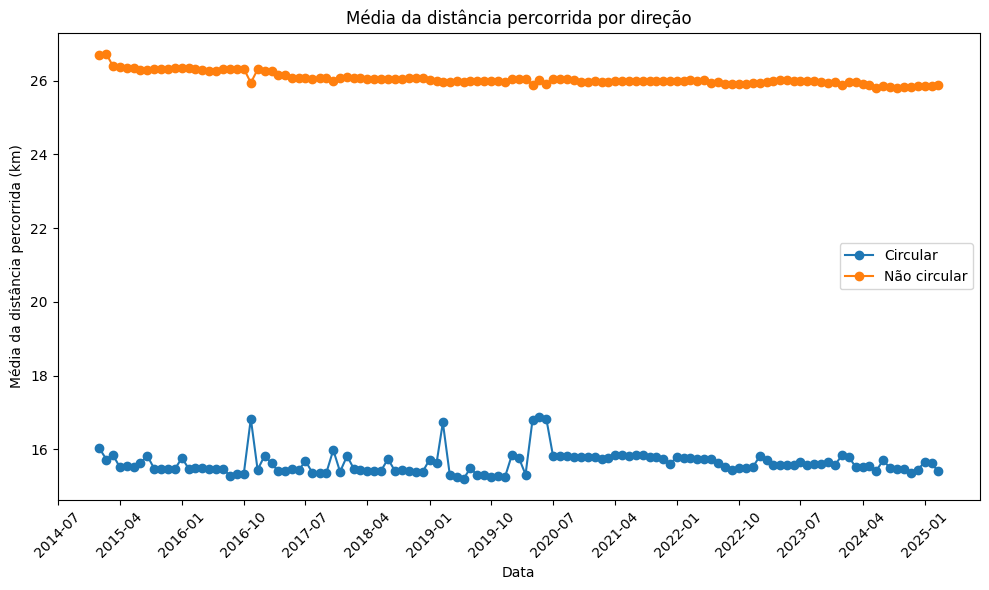

In [37]:
plt.figure(figsize=(10,6))

# Plotar cada direção com uma linha
for direcao in direcoes_unicas:
    subset = df_media[df_media['direcoes'] == direcao]
    plt.plot(subset['data_referencia'], subset['distancia_km_percorrido'], marker='o', label=f'{direcao}')

# Formatar eixo x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=9))  # mostra a cada 3 meses
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # formato ano-mês

plt.xlabel("Data")
plt.ylabel("Média da distância percorrida (km)")
plt.title("Média da distância percorrida por direção")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

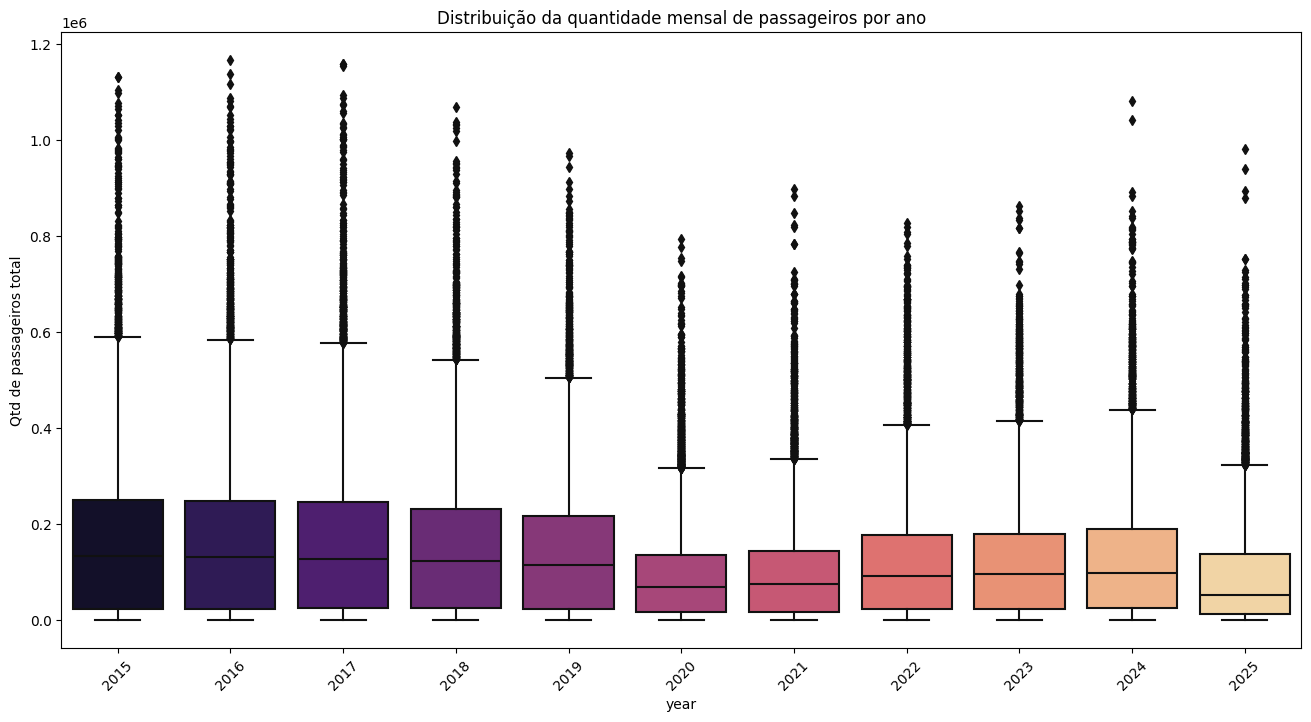

In [38]:
df_pivot=df_passageiros_historico.pivot(values='passageiros_total',columns='year')
plt.figure(figsize=(16,8))
sns.boxplot(data=df_pivot,palette='magma')
plt.xticks(rotation=45)
plt.ylabel('Qtd de passageiros total')
plt.title('Distribuição da quantidade mensal de passageiros por ano')
plt.show()

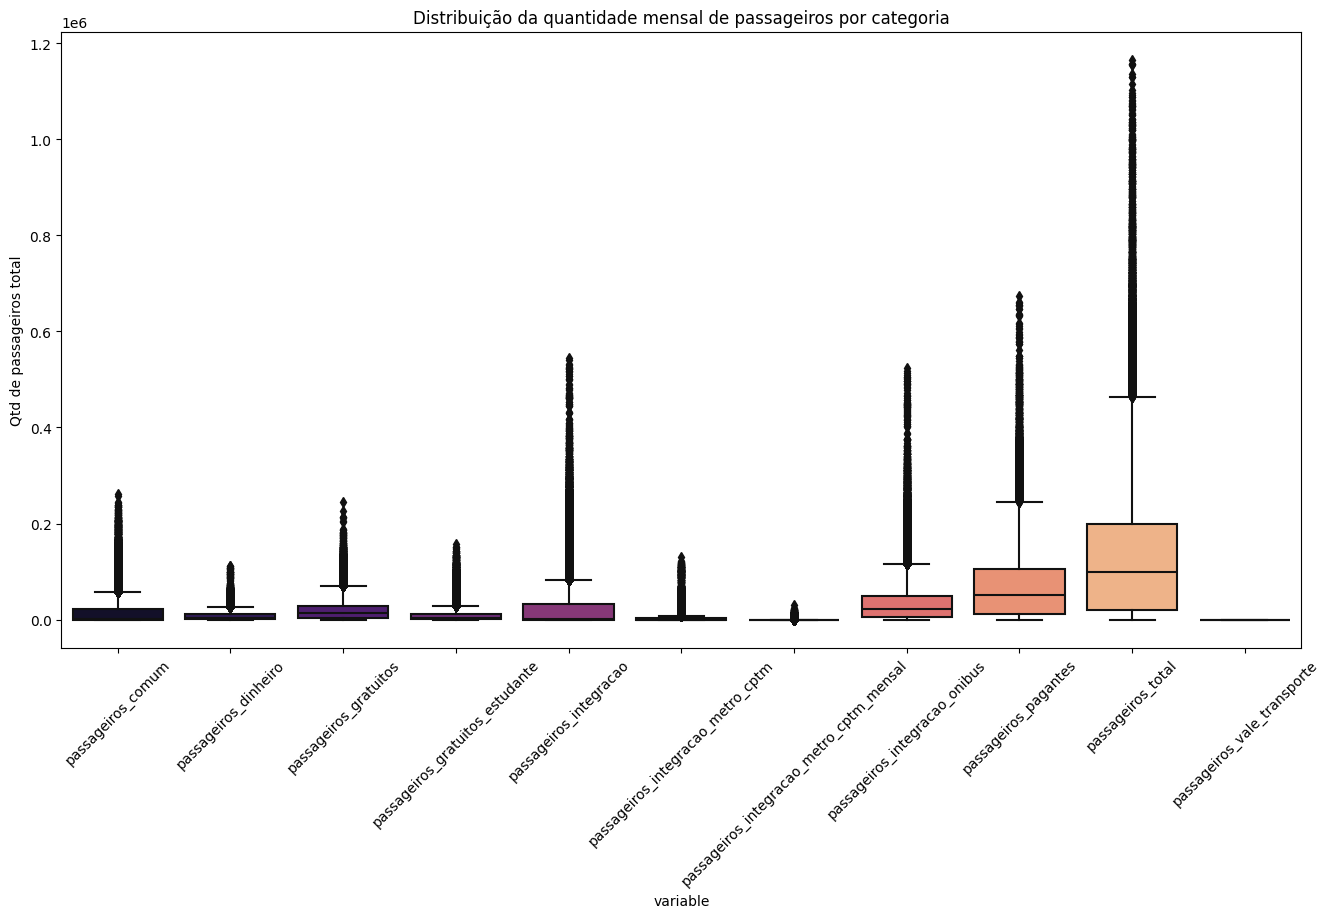

In [39]:
df_meltado=df_passageiros_historico.melt()
df_meltado=df_meltado[df_meltado.variable.str.contains("passag")]
df_categorias_passageiros=df_meltado.pivot(columns='variable',values='value')
plt.figure(figsize=(16,8))
sns.boxplot(data=df_categorias_passageiros,palette='magma')
plt.xticks(rotation=45)
plt.ylabel('Qtd de passageiros total')
plt.title('Distribuição da quantidade mensal de passageiros por categoria')
plt.show()

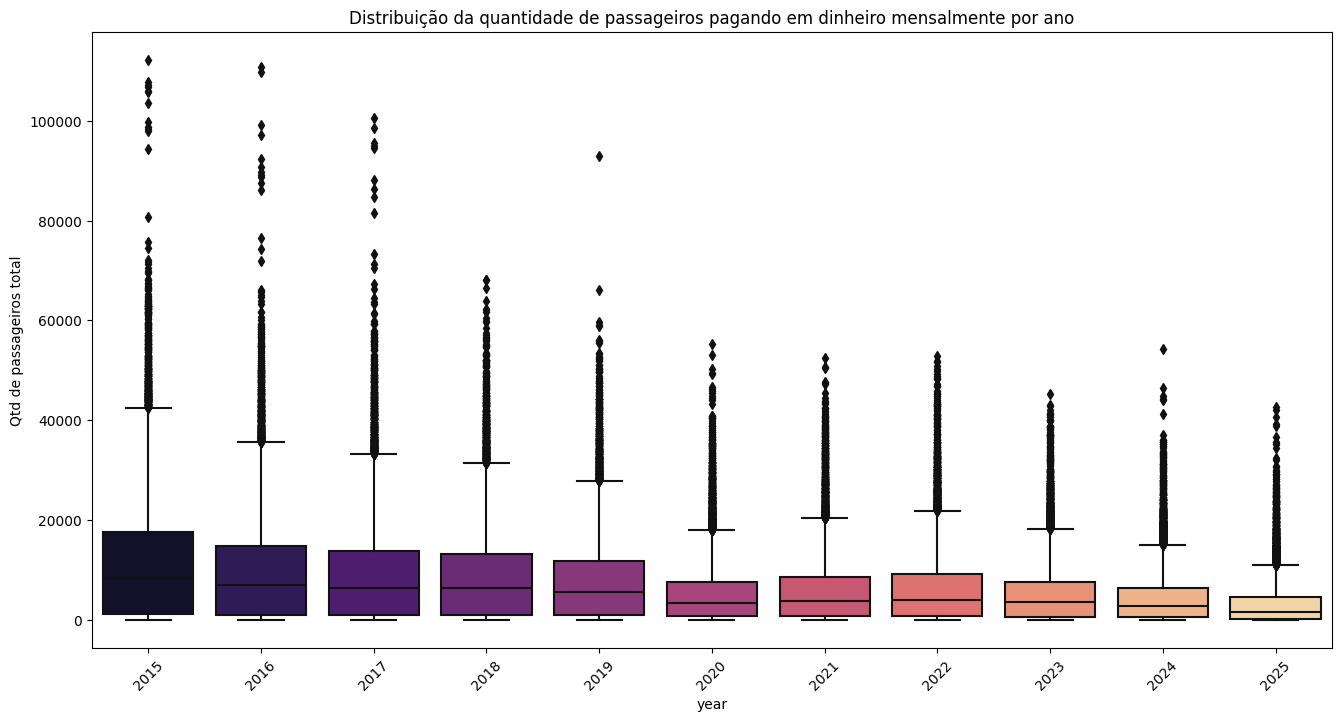

In [40]:
df_pivot=df_passageiros_historico.pivot(values='passageiros_dinheiro',columns='year')
plt.figure(figsize=(16,8))
sns.boxplot(data=df_pivot,palette='magma')
plt.xticks(rotation=45)
plt.ylabel('Qtd de passageiros total')
plt.title('Distribuição da quantidade de passageiros pagando em dinheiro mensalmente por ano')
plt.show()

In [41]:
print(df_passageiros_historico.groupby("linha")[['passageiros_total']].mean().reset_index().sort_values("passageiros_total",ascending=False).head(10).to_latex(index=False))

\begin{tabular}{lr}
\toprule
linha & passageiros_total \\
\midrule
431010 - E.T.ITAQUERA/TERM PQ D PEDRO   & 768837.139535 \\
675K10 - TERM JD ANGELA-METRO STA CRUZ & 730417.403101 \\
220210 - HOSP ITAIM/GUAIAZAZES & 691478.480620 \\
691310 - TERM BANDEIRA/TERM VARGINHA & 667461.651163 \\
607C10 - JD MIRIAM/SHOPP MORUMBI & 651849.271318 \\
870010 - T CAMPO LIMPO/PCA R D AZEVEDO  & 619228.713178 \\
600010 - TERM PARELHEIROS/TERM SANTO AM & 617841.558140 \\
431310 - T CID TIRADENTES/T PQ D PEDRO  & 610069.674419 \\
978T10 - JD GUARANI/METRO BARRA FUNDA & 585280.620155 \\
376310 - TERM VL CARRAO/METRO TATUAPE & 574801.178295 \\
\bottomrule
\end{tabular}



In [42]:
datas_maximas_dist=df_historico_distancia.groupby("route_id")[['data_referencia']].max().reset_index()
df_historico_distancia_mais_recente=df_historico_distancia.merge(datas_maximas_dist,on=['route_id','data_referencia'],how='inner')
df_historico_distancia_mais_recente=df_historico_distancia_mais_recente[['route_id','route_long_name','distancia_km_percorrido']]
print(df_historico_distancia_mais_recente.sort_values("distancia_km_percorrido",ascending=False).head(10).to_latex(index=False))

\begin{tabular}{llr}
\toprule
route_id & route_long_name & distancia_km_percorrido \\
\midrule
331010 & Term. Amaral Gurgel - Cidade Tiradentes (circular) & 90.228783 \\
213C10 & Vila California  - Itaim Paulista, Vl. Califórnia - Itaim Paulista & 75.915440 \\
477P10 & Ipiranga - Rio Pequeno & 70.842332 \\
695Y10 & Term. Parelheiros - Metrô Vila Mariana, Term. Parelheiros - Metrô Vl. Mariana & 68.280425 \\
400251 & Guaianazes - Pq. D.pedro Ii & 67.346256 \\
345910 & Itaim Paulista - Term. Pq. D. Pedro Ii, Itaim Paulista - Term. Pq. D.pedro Ii & 64.141479 \\
536210 & Pq. Res. Cocaia - Pça. Da Sé & 63.219958 \\
393H10 & Terminal Amaral Gurgel - Jd. Sto André & 62.951140 \\
353910 & Cid. Tiradentes - Metrô Bresser, Cidade Tiradentes - Metrô Bresser & 62.516246 \\
957T10 & Cohab Taipas - Itaim Bibi, Cohab Taipas - Vila Olímpia, Cohab Taipas - Vl. Olímpia & 61.882924 \\
\bottomrule
\end{tabular}



In [43]:
df_historico_distancia

,route_id,data_referencia,distancia_metros,distancia_km_percorrido,route_long_name,datas_operacao,direcoes,service_ids,noturna,horas_operacao,regioes,subprefeituras,bairros,populacoes,estacoes_proximas_existentes,estacoes_proximas,beneficiado_por_nova_estacao,estacao_nova_no_bairro,tipo_de_rota_atual,tipo_de_rota_futuro,route_color,route_text_color
0,101210,2016-08-01,9599.714931,9.599715,"Jd Monte Belo - Term Jd Britânia, Jd. Monte Be...",201608 - 202503,Não circular,Todos,True,22.616667,Norte,Perus,Anhanguera,12720.0,,,True,True,Bairro-Bairro,Bairro-Bairro,509E2F,FFFFFF
1,101210,2016-09-01,9599.714931,9.599715,"Jd Monte Belo - Term Jd Britânia, Jd. Monte Be...",201608 - 202503,Não circular,Todos,True,22.616667,Norte,Perus,Anhanguera,12720.0,,,True,True,Bairro-Bairro,Bairro-Bairro,509E2F,FFFFFF
2,101210,2016-10-01,9886.075432,9.886075,"Jd Monte Belo - Term Jd Britânia, Jd. Monte Be...",201608 - 202503,Não circular,Todos,True,22.616667,Norte,Perus,Anhanguera,12720.0,,,True,True,Bairro-Bairro,Bairro-Bairro,509E2F,FFFFFF
3,101210,2016-11-01,9886.075432,9.886075,"Jd Monte Belo - Term Jd Britânia, Jd. Monte Be...",201608 - 202503,Não circular,Todos,True,22.616667,Norte,Perus,Anhanguera,12720.0,,,True,True,Bairro-Bairro,Bairro-Bairro,509E2F,FFFFFF
4,101210,2016-12-01,9886.075432,9.886075,"Jd Monte Belo - Term Jd Britânia, Jd. Monte Be...",201608 - 202503,Não circular,Todos,True,22.616667,Norte,Perus,Anhanguera,12720.0,,,True,True,Bairro-Bairro,Bairro-Bairro,509E2F,FFFFFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158879,N84311,2024-11-01,19211.650124,19.211650,Term. Capelinha - Pq. Arariba,201503 - 202503,Circular,Todos,True,4.916667,Sul,Campo Limpo,"Campo Limpo, Capão Redondo",29449.0,"CAMPO LIMPO, CAPÃO REDONDO, VILA DAS BELEZAS","CAMPO LIMPO, CAPÃO REDONDO, DONATELLO, VILA DA...",True,True,Bairro-Metrô/CPTM,Bairro-Metrô/CPTM,FF671F,000000
158880,N84311,2024-12-01,19211.650124,19.211650,Term. Capelinha - Pq. Arariba,201503 - 202503,Circular,Todos,True,4.916667,Sul,Campo Limpo,"Campo Limpo, Capão Redondo",29449.0,"CAMPO LIMPO, CAPÃO REDONDO, VILA DAS BELEZAS","CAMPO LIMPO, CAPÃO REDONDO, DONATELLO, VILA DA...",True,True,Bairro-Metrô/CPTM,Bairro-Metrô/CPTM,FF671F,000000
158881,N84311,2025-01-01,19211.650124,19.211650,Term. Capelinha - Pq. Arariba,201503 - 202503,Circular,Todos,True,4.916667,Sul,Campo Limpo,"Campo Limpo, Capão Redondo",29449.0,"CAMPO LIMPO, CAPÃO REDONDO, VILA DAS BELEZAS","CAMPO LIMPO, CAPÃO REDONDO, DONATELLO, VILA DA...",True,True,Bairro-Metrô/CPTM,Bairro-Metrô/CPTM,FF671F,000000
158882,N84311,2025-02-01,19211.650124,19.211650,Term. Capelinha - Pq. Arariba,201503 - 202503,Circular,Todos,True,4.916667,Sul,Campo Limpo,"Campo Limpo, Capão Redondo",29449.0,"CAMPO LIMPO, CAPÃO REDONDO, VILA DAS BELEZAS","CAMPO LIMPO, CAPÃO REDONDO, DONATELLO, VILA DA...",True,True,Bairro-Metrô/CPTM,Bairro-Metrô/CPTM,FF671F,000000


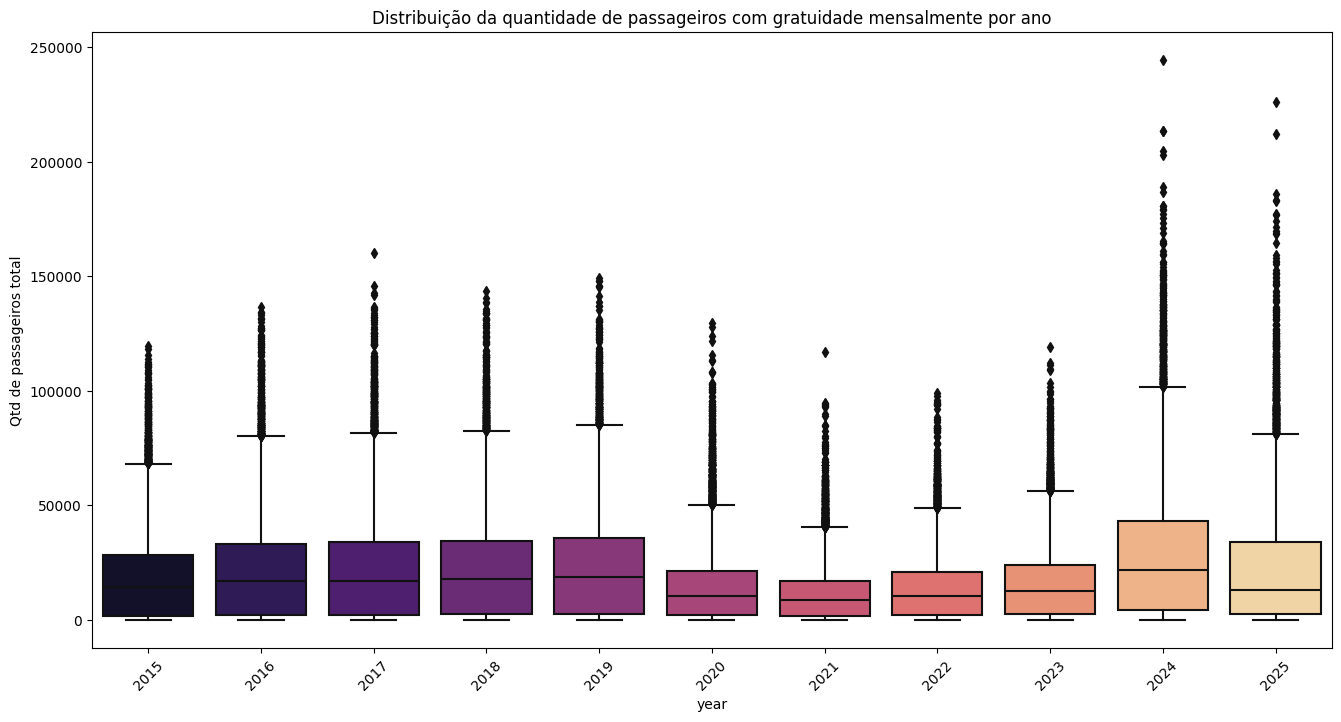

In [44]:
df_pivot=df_passageiros_historico.pivot(values='passageiros_gratuitos',columns='year')
plt.figure(figsize=(16,8))
sns.boxplot(data=df_pivot,palette='magma')
plt.xticks(rotation=45)
plt.ylabel('Qtd de passageiros total')
plt.title('Distribuição da quantidade de passageiros com gratuidade mensalmente por ano')
plt.show()

\begin{tabular}{lr}
\toprule
Palavra & Frequência \\
\midrule
pedro & 142 \\
amaro & 132 \\
santana & 101 \\
lapa & 101 \\
itaquera & 88 \\
santo & 87 \\
capelinha & 80 \\
campo & 79 \\
pinheiros & 69 \\
pirituba & 67 \\
limpo & 66 \\
mateus & 66 \\
barra & 57 \\
varginha & 53 \\
carrão & 52 \\
itaim & 50 \\
cachoeirinha & 50 \\
sacomã & 47 \\
joão & 46 \\
maria & 45 \\
\bottomrule
\end{tabular}



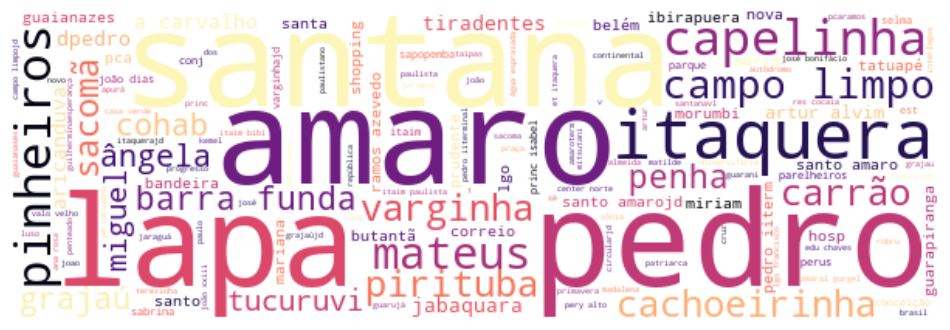

In [45]:
# Junta todos os nomes das rotas em um único texto
texto = ' '.join(
    df_routes['route_long_name'].astype(str).apply(lambda x: " ".join(x.split(","))).str.replace("  ","")
    )

# Remove caracteres especiais e deixa tudo em minúsculas
texto_limpo = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', texto).lower()

# Quebra o texto em palavras
palavras = texto_limpo.split()
stopwords=['do','sto','d','ii','term','metrô','vila','vl','de','pq','shop','jd','jardim','circular','e','terminal','pça','da','cid','cptm','são','sta','das','sao']

palavras=[p for p in palavras if not p in stopwords]

# Conta a frequência de cada palavra
frequencia = Counter(palavras)

# Cria um DataFrame com as 20 palavras mais frequentes
df_freq = pd.DataFrame(frequencia.most_common(20), columns=['Palavra', 'Frequência'])

# Exibe a tabela
print(df_freq.to_latex(index=False))

# Cria a nuvem de palavras
nuvem = WordCloud(
    width=600,
    height=200,
    background_color='white',
    colormap='magma',
    max_words=500,
    stopwords = stopwords
).generate(' '.join(palavras))

# Exibe a nuvem
plt.figure(figsize=(12, 6))
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
# plt.title('Nuvem de Palavras - route_long_name', fontsize=16)
plt.show()

In [46]:
frequencia['cohab']

42